# AOS_repackager2

Developing the new repackager after updates to `focalplanelayout.txt` and `segmentation.txt` that aligned the corner sensor names and channel names (for corner sensors) with lsstCamMapper. 

In [1]:
import os
import sys
import glob
import time
import numpy as np
from collections import defaultdict
import astropy.io.fits as fits
import astropy.time
from lsst.obs.lsst import LsstCam

    

In [29]:
# READ THE SENSOR FILES 

#visit_dir = '/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/'
#visit_dir = '/project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/'
#visit_dir = '/project/scichris/aos/segmentation_update/comcam/arrows/'
#visit_dir = '/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/'
visit_dir = '/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/'
#visit_dir = '/project/scichris/aos/segmentation_update/famcam/raftR01/'
prefix='lsst'
phosim_amp_files \
            = sorted(glob.glob(os.path.join(visit_dir, f'{prefix}_a_*')))
amp_files = defaultdict(list)

    
for item in phosim_amp_files:
        sensor_id = '_'.join(os.path.basename(item).split('_')[4:6])
        amp_files[sensor_id].append(item)
out_dir =  os.path.join(visit_dir, 'repackaged5_rmROTSTART')
#out_dir =  '/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/'      
            

In [25]:
#phosim_amp_files

In [30]:
def noao_section_keyword(bbox, flipx=False, flipy=False):
    """
    Convert bounding boxes into NOAO section keywords.

    Parameters
    ----------
    bbox : lsst.afw.geom.Box2I
        Bounding box.
    flipx : bool
        Flag to indicate that data should be flipped in the x-direction.
    flipy : bool
        Flag to indicate that data should be flipped in the y-direction.
    """
    xmin, xmax = bbox.getMinX()+1, bbox.getMaxX()+1
    ymin, ymax = bbox.getMinY()+1, bbox.getMaxY()+1
    if flipx:
        xmin, xmax = xmax, xmin
    if flipy:
        ymin, ymax = ymax, ymin
    return '[%i:%i,%i:%i]' % (xmin, xmax, ymin, ymax)


def repackage(phosim_amp_files, out_dir='.', verbose=True):
    # parts of 'repackage_corner '

    # take channel reading from 'repackage_main'... perhaps won't need a separate function for 
    # 'repackage_corner...'
    

    segments = {}
    for filename in phosim_amp_files:
        phosim_channel = os.path.basename(filename).split('_')[6][1:]
        segments[phosim_channel] = fits.open(filename)[0]

    # Read raft name from the last filename
    raft = os.path.basename(filename).split('_')[4]
    ccdslot = os.path.basename(filename).split('_')[5]
    sensorId = '%s_%s'%(raft, ccdslot)
    print('Repackaging sensor %s '%(sensorId))

    camera = LsstCam().getCamera()
    detectors = camera.get(sensorId)
    TELCODE = 'MC'
    CONTRLLR = 'H'

    # initialize the FITS file
    sensor = fits.HDUList(fits.PrimaryHDU())

    # Set the NOAO section keywords based on the pixel geometry
    # in the obs_lsst object for each amplifier header
    for amp in detectors:
        ampName = amp.getName()[1:]
        if verbose:
            print(ampName)
        hdu = segments[ampName]
        hdu.header['EXTNAME'] = 'Segment%s' % ampName
        hdu.header['DATASEC'] = noao_section_keyword(amp.getRawDataBBox())
        hdu.header['DETSEC'] = noao_section_keyword(
            amp.getBBox(),
            flipx=amp.getRawFlipX(),
            flipy=amp.getRawFlipY())

        
        # flip up-down the corner sensor intra-focal images for correct orientation
        # note: all corner sensors have amps labelled 10:17
#         if ccdslot == 'SW1':
#             if verbose:
#                 print('Flipping up-down..')
#             data = np.copy(hdu.data)
#             hdu.data[:] = np.flipud(data)

        # Remove the incorrect BIASSEC keyword that phosim writes
        try:
            hdu.header.remove('BIASSEC')
        except KeyError:
            pass
        sensor.append(hdu)

    # Set keywords in primary HDU, extracting most of the relevant
    # ones from the first phosim amplifier file.
    sensor[0].header['EXPTIME'] = sensor[1].header['EXPTIME']
    sensor[0].header['DARKTIME'] = sensor[1].header['DARKTIME']
    sensor[0].header['RUNNUM'] = sensor[1].header['OBSID']
    sensor[0].header['MJD-OBS'] = sensor[1].header['MJD-OBS']
    DATEOBS = astropy.time.Time(sensor[1].header['MJD-OBS'], format='mjd').isot
    sensor[0].header['DATE-OBS'] = DATEOBS
    YEAR, MONTH, DAYTIME = DATEOBS.split('-')
    DAY = DAYTIME[:2]
    DAYOBS = '%s%s%s'%(YEAR, MONTH, DAY)
    sensor[0].header['DAYOBS'] = DAYOBS

    DATE = sensor[1].header['DATE']  # file creation date
    sensor[0].header['DATE'] = DATE
    sensor[0].header['MJD'] = astropy.time.Time(DATE, format='isot').mjd

    sensor[0].header['FILTER'] = sensor[1].header['FILTER']

    serial = detectors.getSerial()  # eg. ITL-4400B-029
    CCD_MANU, CCD_TYPE, CCD_NUM = serial.split('-')
    sensor[0].header['LSST_NUM'] = serial
    sensor[0].header['CCD_MANU'] = CCD_MANU  # eg. ITL
    sensor[0].header['CCD_TYPE'] = CCD_TYPE  # eg. 4400B

    # NB: I get [1:4072,1:2000], whereas  BOT has '[1:4072,1:4000]'
    sensor[0].header['DETSIZE'] = noao_section_keyword(detectors.getBBox())
    sensor[0].header['INSTRUME'] = 'lsstCam'
    sensor[0].header['TELESCOP'] = 'LSST'

    sensor[0].header['TELCODE'] = TELCODE
    sensor[0].header['CONTRLLR'] = CONTRLLR
    # Set sequence number from OBSID, eg. 9006001, taking
    # the last 6 digits
    SEQNUM = int(sensor[0].header['RUNNUM'][-6:])
    sensor[0].header['SEQNUM'] = SEQNUM

    OBSID = "%s_%s_%s_%s"%(TELCODE, CONTRLLR, DAYOBS, str(SEQNUM).zfill(6))
    sensor[0].header['OBSID'] = OBSID

    sensor[0].header['TESTTYPE'] = 'PHOSIM'
    sensor[0].header['IMGTYPE'] = 'SKYEXP'
    sensor[0].header['RAFTBAY'] = raft
    sensor[0].header['CCDSLOT'] = ccdslot
    sensor[0].header['RASTART'] = sensor[1].header['RA_DEG']
    sensor[0].header['DECSTART'] = sensor[1].header['DEC_DEG']
    #sensor[0].header['ROTSTART'] = sensor[1].header['ROTANG']
    sensor[0].header['RA'] = sensor[1].header['RA_DEG']
    sensor[0].header['DEC'] = sensor[1].header['DEC_DEG']
    sensor[0].header['ROTPA'] = sensor[1].header['ROTANG']
    sensor[0].header['ROTPOS'] = sensor[1].header['ROTANG']
    sensor[0].header['ROTANGLE'] = sensor[1].header['ROTANG']
    sensor[0].header['ROTCOORD'] = 'sky' # needed 
    
    sensor[0].header['AMSTART'] = sensor[1].header['AIRMASS']
    #sensor[0].header['IMGTYPE'] = 'SKYEXP'
    sensor[0].header['ELSTART'] = 90.-sensor[1].header['ZENITH'] # convert zenith angle to altitude

    # Filename created from TELCODE, CONTRLLR, DAYOBS, SEQNUM , raft, ccdslot.
    # eg. MC_C_20200825_000032_R00_SW0.fits
    # Below, OBSID already contains TELCODE, CONTRLLR, DAYOBS, str(SEQNUM).zfill(6)
    filename = '%s_%s_%s.fits'%(OBSID, raft, ccdslot)
    filename = os.path.join(out_dir, filename)

    # save the FITS file
    sensor.writeto(filename, overwrite=True)
    print('Saved as %s'%filename)

In [60]:
#$hdul[1].header

In [32]:
# choose one sensor
sensor_id='R22_S12'
phosim_amp_files = amp_files[sensor_id]
repackage(phosim_amp_files, out_dir=out_dir)

Repackaging sensor R22_S12 
10
11
12
13
14
15
16
17
07
06
05
04
03
02
01
00
Saved as /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged5_rmROTSTART/MC_H_20000217_006001_R22_S12.fits


In [6]:
for sensor_id in amp_files:
    repackage(amp_files[sensor_id], out_dir=out_dir,verbose=False)

Repackaging sensor R01_S00 
Saved as /project/scichris/aos/segmentation_update/famcam/raftR01/repackaged/MC_H_20160916_009999_R01_S00.fits
Repackaging sensor R01_S01 
Saved as /project/scichris/aos/segmentation_update/famcam/raftR01/repackaged/MC_H_20160916_009999_R01_S01.fits
Repackaging sensor R01_S02 
Saved as /project/scichris/aos/segmentation_update/famcam/raftR01/repackaged/MC_H_20160916_009999_R01_S02.fits
Repackaging sensor R01_S10 
Saved as /project/scichris/aos/segmentation_update/famcam/raftR01/repackaged/MC_H_20160916_009999_R01_S10.fits
Repackaging sensor R01_S11 
Saved as /project/scichris/aos/segmentation_update/famcam/raftR01/repackaged/MC_H_20160916_009999_R01_S11.fits
Repackaging sensor R01_S12 
Saved as /project/scichris/aos/segmentation_update/famcam/raftR01/repackaged/MC_H_20160916_009999_R01_S12.fits
Repackaging sensor R01_S20 
Saved as /project/scichris/aos/segmentation_update/famcam/raftR01/repackaged/MC_H_20160916_009999_R01_S20.fits
Repackaging sensor R01_S21 

## Correct repackager for e-images too 

In [13]:
import glob
import os 
visit_dir = '/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/'
#visit_dir = '/project/scichris/aos/segmentation_update/famcam/raftR01/'
prefix='lsst'
phosim_eimg_files \
            = sorted(glob.glob(os.path.join(visit_dir, f'{prefix}_e_*')))
phosim_eimg_file = phosim_eimg_files[0]
out_dir =  os.path.join(visit_dir, 'repackaged')


In [14]:
def repackage_eimage(phosim_eimg_file, out_dir='.', verbose=False):
    """Repackage the phosim eimage file to the format required by obs_lsst.

    Parameters
    ----------
    phosim_eimg_file : str
        PhoSim eimage file.
    out_dir : str, optional
        Output directory (the default is '.'.)
    verbose: bool, optional
        Set to True to print out processing information.
    """
    
    camera = LsstCam().getCamera()
    
    TELCODE = 'MC'
    CONTRLLR = 'H'

    sensor = fits.open(phosim_eimg_file)[0]

    filename = phosim_eimg_file
    raft = os.path.basename(filename).split('_')[4]
    ccdslot = os.path.basename(filename).split('_')[5]
    sensorId = '%s_%s'%(raft, ccdslot)
    print('Repackaging sensor %s '%(sensorId))
    
    detectors = camera.get(sensorId)
    
    # Set BOT-like keywords in the HDU
    sensor.header['EXPTIME'] = sensor.header['EXPTIME']
    sensor.header['DARKTIME'] = sensor.header['DARKTIME']
    sensor.header['RUNNUM'] = sensor.header['OBSID']
    sensor.header['MJD-OBS'] = sensor.header['MJD-OBS']

    DATEOBS = astropy.time.Time(sensor.header['MJD-OBS'], format='mjd').isot
    sensor.header['DATE-OBS'] = DATEOBS

    YEAR, MONTH, DAYTIME = DATEOBS.split('-')
    DAY = DAYTIME[:2]
    DAYOBS = '%s%s%s'%(YEAR, MONTH, DAY)
    sensor.header['DAYOBS'] = DAYOBS

    # file creation date as mjd
    sensor.header['MJD'] = astropy.time.Time(sensor.header['DATE'],
                                             format='isot').mjd

    serial = detectors.getSerial()  # eg. ITL-4400B-029
    CCD_MANU, CCD_TYPE, CCD_NUM = serial.split('-')
    sensor.header['LSST_NUM'] = serial
    sensor.header['CCD_MANU'] = CCD_MANU  # eg. ITL
    sensor.header['CCD_TYPE'] = CCD_TYPE  # eg. 4400B

    sensor.header['DETSIZE'] = noao_section_keyword(detectors.getBBox())
    sensor.header['INSTRUME'] = 'lsstCam'
    sensor.header['TELESCOP'] = 'LSST'

    sensor.header['TELCODE'] = TELCODE
    sensor.header['CONTRLLR'] = CONTRLLR
    SEQNUM = int(sensor.header['RUNNUM'][-6:])
    sensor.header['SEQNUM'] = SEQNUM

    OBSID = "%s_%s_%s_%s"%(TELCODE, CONTRLLR, DAYOBS, str(SEQNUM).zfill(6))
    sensor.header['OBSID'] = OBSID

    sensor.header['TESTTYPE'] = 'PHOSIM'
    sensor.header['IMGTYPE'] = 'SKYEXP'

    sensor.header['RAFTBAY'] = raft
    sensor.header['CCDSLOT'] = ccdslot

    sensor.header['RASTART'] = sensor.header['RA_DEG']
    sensor.header['DECSTART'] = sensor.header['DEC_DEG']
    sensor.header['ROTSTART'] = sensor.header['ROTANG']

    sensor.header['RA'] = sensor.header['RA_DEG']
    sensor.header['DEC'] = sensor.header['DEC_DEG']
    sensor.header['ROTPA'] = sensor.header['ROTANG']
    sensor.header['ROTPOS'] = sensor.header['ROTANG']
    
    sensor.header['ROTANGLE'] = sensor.header['ROTANG']
    sensor.header['ROTCOORD'] = 'sky' # needed 
    
    sensor.header['AMSTART'] = sensor.header['AIRMASS']
    sensor.header['ELSTART'] = 90.-sensor.header['ZENITH'] # convert zenith angle to altitude

    # Transpose the image to fulfill the geometry of postISRCCD by obs_lsst
    sensor.data = sensor.data.T

    # get a filename from TELCODE, CONTRLLR,  DAYOBS, SEQNUM , raft, ccdslot
    # eg. MC_H_20200825_000032_R00_SW0.fits
    filename = '%s_%s_%s_e.fits'%(OBSID, raft, ccdslot)
    filename = os.path.join(out_dir, filename)

    # save the FITS file
    sensor.writeto(filename, overwrite=True)
    print('Saved as %s'%filename)

In [54]:
# choose one sensor
repackage_eimage(phosim_eimg_file, out_dir=out_dir)

Repackaging sensor R22_S00 
Saved as /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S00_e.fits


## check the ingested raw e-img file 

**comcam** 

     cd /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/
     mkdir input_2021_07
     cd input_2021_07
     echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
     
     

Finish DM-28046 (ingestion of e-images). 

Options to follow: 

* (a) Follow Tim's advice of creating `LsstCamEimgParseTask` rather than changing `PhosimEimgParseTask`. Thus I'll undo the changes to `phosim.py` and `test_parsetask.py`, and add the `LsstCamEimgParseTask` to `ingest.py` (https://github.com/lsst/obs_lsst/blob/master/python/lsst/obs/lsst/ingest.py). That way the previous places that used `--config phosim.py` with `PhosimEimgParseTask` to ingest old phosim e-images will not break. Also, that way when we integrate the usage of `LsstComCam`, we'll need `LsstComCamEimgParseTask` inside https://github.com/lsst/obs_lsst/blob/master/python/lsst/obs/lsst/comCam.py 

Or

* (b) Keep changes to `phosim.py`. It'll break all files repackaged earlier, but that may be fine because we're updating the repackager. That way no changes are needed to `ts_wep`, apart from updating the test files. Only update the `tests/test_parsetask.py` `test_parsetask_phosim_eimg_translator()` with appropriate new `e-image` test file . The drawback is what do we do when we need to ingest `LsstComCam` e-images from phosim, and they need a parsetask too ? 


I choose (a). Thus I first undo the last two commits:
    
    cd /project/scichris/dev/obs_lsst
    git checkout tickets/DM-28046
    git reset --hard HEAD~2  # to remove all changes done by the two previous commits: one that removed the `test_parsetask_phosim_eimg_translator()` - aabf6cf137f6aa4091bfd0f745d57804b934e7a7  and the previous one that updates `phosim.py`- 50f3092aad6778d8a27bf1a4391f4f50d8898e0f
    
    
Then I edit `ingest.py` adding `LsstCamEimgParseTask()`:

    cd python/lsst/obs/lsst/ingest.py
    
Try translating the repackaged e-image :


    translate_header.py -p lsst.obs.lsst.translators  /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S00_e.fits
    
    
Try ingesting : 

    
    ingestImages.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_07/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/*_e.fits
    
    
    
It becomes raw, because it doesn't know it's an e-image... Need to add a config:  `config/lsstCam/ingestEimg.py`, and do the above as 

    ingestImages.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_07/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/*_e.fits --configfile /project/scichris/dev/obs_lsst/config/lsstCam/ingestEimg.py 
    
    
Ok ,that ingests as I wish. Show the ingested e-image files: 

/project/scichris/dev/obs_lsst/python/lsst/obs/lsst/lsstCamMapper.py:157: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  for n in afwImage.Filter.getNames():


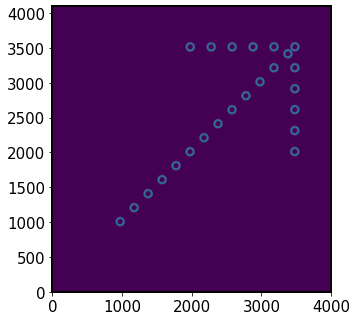

In [36]:
#It is possible to read the data with butler on LSP, I tried 
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_07/'
butler = dafPersist.Butler(dataRoot, )
dataId = dict(run='9006001', raftName='R22', detectorName='S00')

# butler.queryMetadata('eimage', ['dayObs', 'visit'], dataId, )#seqNum=31)
# can use that to figure out what are the other data for that image...
# anything short of using sqlite3... 
post = butler.get('eimage', dataId)
image = post.image.array


# this would read the original uningested e-image, and we see it's correctly the same file ... 
# hdu = fits.open('/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S00_e.fits')

# THE UNTRANSPOSED IMAGE, SHOWING WHY UP-DOWN FLIP WAS NEEDED 
# fig,ax = plt.subplots(1,1,figsize=(5,10))
# ax.imshow(image, origin='lower',vmax=2000)

# THE TRANSPOSED IMAGE: SHOWING THE CORRECT ORIENTATION ... 
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=50)


Ok, we're done, because there's no ISR stage for e-images (they already do not have any instrument signature that would require removal). I commit the two changed files :

    git add python/lsst/obs/lsst/ingest.py
    git commit -m 'added LsstCamEimgParseTask'

    git add config/lsstCam/ingestEimg.py
    git commit -m 'added configfile for LsstCamEimg'
    
    flake8 python/lsst/obs/lsst/ingest.py  # fixed whitespace
    git add python/lsst/obs/lsst/ingest.py
    git commit -m 'fixed whitespace for ingest.py' 

    flake8 config/lsstCam/ingestEimg.py # here everything was fine 

Will need to rebase at the end to only keep the right commit messages . 

    

Need to add a test to `LsstCamEimgParseTask` : 

    cd /project/scichris/dev/obs_lsst/tests/
    pytest test_parsetask.py # runs the indvidual test .. 
    
Edited `test_parsetask.py` , adding the test  


Also, copied the ingested e-image file : 
       
    cd /project/scichris/dev/obs_lsst/data/input/lsstCam/
    mkdir eimage/4000021706001/E000/R22 
    cd eimage/4000021706001/E000/R22
    cp /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_07/eimage/4000021706001/E000/R22/eimage_4000021706001_R22_S00_E000.fits.gz . 

But note that file was a symlink to the original location ( ` lsstCam/eimage/4000021706001/E000/R22/eimage_4000021706001_R22_S00_E000.fits.gz -> /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S00_e.fits`)

Then changed the symlink to a regular file that it points to : 

    cd /project/scichris/dev/obs_lsst/data/input/lsstCam/eimage/4000021706001/E000/R22
    for f in $(find -type l);do cp --remove-destination $(readlink $f) $f;done;

( after  https://stackoverflow.com/questions/8377312/how-to-convert-symlink-to-regular-file) .

But now my file is still ~65 MB. Need to strip it to be as small as the analogous phosim e-image file : 



In [48]:
# phosim e-image test file
hdul = fits.open('/project/scichris/dev/obs_lsst/data/input/phosim/eimage/9006002/E000/R22/eimage_09006002_R22_S00_E000.fits.gz')

In [16]:
from astropy.io import fits
# lsstCam e-image test file repackaged not ingested
fname = '/project/scichris/aos/segmentation_update/comcam/\
arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S00_e.fits'
hdul = fits.open(fname)
hdul0 = hdul[0]
print(hdul0.header['RADESYS'])
hdul.close()

ICRS


In [17]:
#hdul0.header

In [79]:
# lsstcam e-image test ingested 
fpath = '/project/scichris/dev/obs_lsst/data/input/lsstCam/eimage/4000021706001/E000/R22/eimage_4000021706001_R22_S00_E000.fits'
hdul1 = fits.open(fpath)
hdul1[0].data[:] = 0 # set all to 0 
newFpath ='/project/scichris/dev/obs_lsst/data/input/lsstCam/eimage/4000021706001/E000/R22/eimage_4000021706001_R22_S00_E000.fits.gz'
hdul1.writeto(newFpath, overwrite=True) 



In [64]:
fpath = '/project/scichris/dev/obs_lsst/data/input/lsstCam/eimage/4000021706001/E000/R22/eimage_4000021706001_R22_S00_E000.fits'
hdul1 = fits.open(fpath)
hdul1

Ok, so when I do  `hdul1.writeto('filename.fits.gz')` astropy does the compression, and in this case it shrank the file from 63 MB to 62k (!).  

Now I can commit the test file : 
    
    cd /project/scichris/dev/obs_lsst/
    git add /data/input/lsstCam/eimage/4000021706001/E000/R22/eimage_4000021706001_R22_S00_E000.fits.gz
    git commit -m 'added testfile for test_parsetask_lsstCamEimg_translator'
    

Now I clean the commit history by doing rebase: 
    
    git rebase -i 040bd48b25b9464589734d647c13e34b85f8d1a6

I make it as 

    pick df7a6a0 added configfile for LsstCamEimg
    squash fc05d49 fixed whitespace for ingest.py
    pick 75eeba7 added test for LsstCamEimgParseTask
    squash 3c960a8 added testfile for test_parsetask_lsstCamEimg_translator

and hit `escape` to quit the edit mode, and `:wq` to write and quit. 
    

Then I need to do the interactive rebase against master https://developer.lsst.io/work/flow.html?highlight=rebase

    git rebase -i master


Then I push all changes to the ticket branch 

    git push --force 
    
Then I need to run it on Jenkins:
    
* go to https://ci.lsst.codes/blue/organizations/jenkins/stack-os-matrix/activity/ 

* click "Run" in the top-left 
  * enter "tickets/DM-28046" in the top box 
  * enter "obs_lsst" in the second box (besides "lsst_distrib lsst_ci" ) ) 
  * leave the "conda env ref" default



Now need to make tests for test_phosim_repackager.py using 4 ccds .

main raft e-image, 
corner raft e-image, 
main raft amp images (16 amp files)
corner raft amp images (8 amp files)

But since the repackaging process is identical for main raft and corner raft (they're no longer separate functions), perhaps just repackagin one main raft ccd would be enough. 

    cd /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2
    thresholdFits.py lsst_a_9006001_f1_R22_S22*      # <--- main raft ; also reduced ~10 times the filesize 
    thresholdFits.py lsst_e_9006001_f1_R22_S22_E000.fits.gz -t 1     # <-- main raft e-image : from 783k to 124k
    
I first repackage by hand and see what the content is to be able to update the test : 

    cd /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/thresholded
    phosim_repackager.py . --eimage
    phosim_repackager.py . 
    

In [25]:
# check the repackaged  eimage properties 
from astropy.io import fits
hdul = fits.open('/project/scichris/aos/segmentation_update/\
comcam/arrowsUpdSerial2/thresholded/eimage/MC_H_20000217_006001_R22_S22_e.fits')[0]


In [1]:
# check the repackaged amp image properties
from astropy.io import fits
hdul = fits.open('/project/scichris/aos/segmentation_update/\
comcam/arrowsUpdSerial2/thresholded/v9006001-g/MC_H_20000217_006001_R22_S22.fits')

In [17]:
import numpy as np 
hdul[0].header['CCDSLOT']

'S22'

In [ ]:
sensor = fits.open(eimg_file)[0]

Now that all changes got added and all tests pass, rebase to master to clean commits 

    git rebase -i master

Shows

    pick 7216003 repackager handling the corner sensors
    pick a4e5093 add test for amp image and e-image 
    pick 7b4073d fixed seqnum and adding _e to e-image
    pick aae1a86 added repackager for lsstCam
    pick dea039b switched to lsstCam mapper`
    pick 8a0519c changed Filter to FilterLabel
    pick 8fef569 added ROTCOORD, AMSTART, ELSTART keywords
    pick 0cc9413 cleaned whitespace
    pick 04051cf updated e-image repackaging and cleaned
    pick 7a90cee working unit test for main raft e-image
    pick 9d7d6f0 FITS thresholding task
    pick d23c455 cleaned up
    pick 61521a6 updated e-image filename
    pick 70a1d66 reformat by black
    pick 1dfa114 added tests for amp files
    pick 65d094a delete old test file
    
I pick 

pick 8a0519c Update makeGainImages
squash dea039b makeGainImages 
squash 0cc9413 makeGainImages

pick 7216003 Update repackager 
squash 7b4073d repackager
squash aae1a86 repackager
squash 8fef569 repackager
squash 04051cf repackager
squash d23c455 repackager

pick 61521a6 Update e-image test
squash a4e5093 test
squash 7a90cee test
squash 70a1d66 reformat by black

pick 1dfa114 Add tests for amp files
pick 9d7d6f0 Add FITS thresholding task 



Then resolve all merge conflicts in text files, pick commits, etc.. 

Then I rebase against master  just in case ( to be up-to-date and ready to merge .... ) 

    git checkout master 
    git pull
    git checkout tickets/DM-26836
    git rebase -i master 


Then 
   
    git push --force 
    
And do the PR ! 

Useful site https://ljvmiranda921.github.io/notebook/2018/06/21/precommits-using-black-and-flake8/ 

## Dealing with the review to phosim_utils update 

In [ ]:
I made changes following Te-Wei's comments. All pass scons. I do 

    git rebase -i master 
    
And reorganize the commits. From 

    pick 31143e5 Change Filter to FilterLabel
    pick de9df80 Updated repackager to use lsstCamMapper
    pick 19773d1 Update e-image filename
    pick 88795d1 added tests for amp files
    pick d303245 Add new amp and eimage test files
    pick 8ccc341 Add FITS thresholding task
    
    
    pick abd912f Fix amp file test
    
    pick 6417d91 add class comments and remove verbose
    pick c841f4a fix filename assignment
    pick d45f82a remove MJD-OBS from eimage header
    pick 86719fe removed EXPTIME and DARKTIME from eimage header
    pick 0148a5b remove ROTPOS

    pick f487a59 changed self.telcode to self.TELCODE
    pick 25c28b1 moved TELCODE and CONTRLLR as class constants
    pick b9a1c92 fixed thresholdFits comments
    pick f00d246 add closing of eimage test file
    pick fb0c7b0 removed --keep_original_value option as a default --not_binary behavior

    
I do :
    
    pick 8ccc341 Add FITS thresholding task
    squash fb0c7b0 Remove --keep_original_value kwarg 
    squash b9a1c92 Fix thresholdFits comments
    
    pick 19773d1 Update repackager tests 
    squash 88795d1 Add tests for amp files
    squash d303245 Add new amp and eimage test files
    squash f00d246 Close e-images
    squash abd912f Close amp file
    
    pick de9df80 Update the repackager to use lsstCamMapper
    squash 25c28b1 Fix the repackager redundancies
    squash f487a59 Change self.telcode to self.TELCODE
    squash d45f82a Redundant MJD-OBS from eimage header
    squash 86719fe Redundant EXPTIME and DARKTIME from eimage header
    squash 0148a5b Redundant ROTPOS
    squash c841f4a Fix filename assignment
    squash 6417d91 Add class comments and remove verbose option
    
    pick 31143e5 Change Filter to FilterLabel
    
    
    
    
    
    

# Changes to ts_wep

Because of the new repackager, multiple files need changes in ts_wep. Specifically:
    
    camIsrWrapper.py  : change doCrosstalk       to False (since no crosstalk coeffs for lsstCam in the mapper)

    WEPCalculation.py  : 
        add camMapper as "lsstCam" 
        change search pattern for amp images, adding _getAmpImagesFromDir() method - NEED TEST 
        

    policy/default.yaml : change camMapper from "phosim" to "lsstCam"

    CamDataCollector.py : add genLsstCamMapper() ; change config path for ingestEimages() to look in 'obs_lsst' from 'phosim' to 'lsstCam'

    ButlerWrapper.py : change default dataId  from expId to run 
    
    
    
Update tests: 

    tests/test_butlerWrapper.py
    tests/test_camDataCollector.py
    tests/test_camIsrWrapper.py
    tests/test_sourceProcessor.py 

    tests/ctrlIntf/test_wEPCalculation.py 
    tests/test_wepControllerMonolithic.py 

    --> all will use tests/testData/phosimOutput/realComcam/repackagedFiles/intra/.....

I make the new test data taking the iter0 files (OPD and repackaged images) for comcam. The corner sensor data in `/phosimOutput/realWfs` are not used in any tests yet, and will be updated at a later time .


I make sure to use on NCSA lsst-devl03 :

- the new repackager (`phosim_utils` `master`)   
- updated segmentation file (`phosim_syseng4` `aos` branch)
- updated gain/readNoise values (`obs_lsst` `tickets/DM-28553` branch ) 
- updated ts_wep code (`ts_wep` `tickets/DM-28330` branch ) 
    
    python bin.src/imgCloseLoop.py --inst comcam --numOfProc 25 --boresightDeg 0.03 -0.02 --skyFile /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/skyComCamInfo.txt --output /project/scichris/aos/segmentation_update/comcam/imgCloseLoop3



    
    

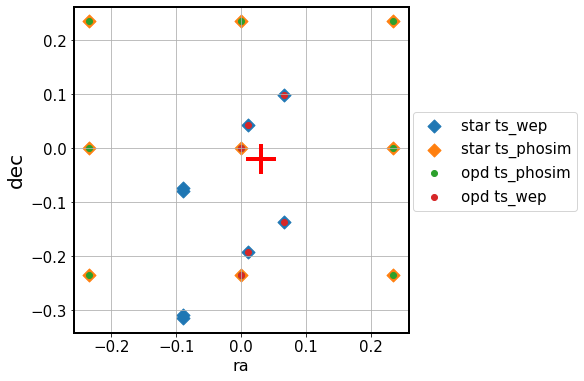

In [32]:
# show the skyfile used for the simulation ; use the default cmd files for ts_phosim .... 
import numpy as np 
import matplotlib.pyplot as plt 

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

p1 = '/project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/skyComCamInfo.txt'
p2 = '/project/scichris/aos/ts_phosim/tests/testData/sky/skyComCam.txt'


fig,ax = plt.subplots(1,1,figsize=(6,6))
for pathSkyFile, label in zip([p1,p2], ['ts_wep', 'ts_phosim',],):
                    
    radec = np.loadtxt(pathSkyFile)
    ra,dec = radec[:,1],radec[:,2]
    ra[ra>180] = ra[ra>180]-360
    ax.scatter(ra,dec, label='star '+label, marker='D', s=85)

p3 = '/project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/opdLocations.txt'  # from ts_wep : 5 locations 
p4 = '/project/scichris/aos/ts_wep/tests/testData/opdOutput/9005000/opdLocations.txt'  # from ts_phosim: 9 locations

for pathOpdFile, label in zip([p3,p4],['ts_phosim', 'ts_wep']):
    opd = np.loadtxt(pathOpdFile,dtype='str')
    ra = opd[:,2].astype('float')
    dec = opd[:,3].astype('float')
    ax.scatter(ra,dec, label='opd '+label)
    
ax.plot(0.03,-0.02, marker='+', markersize=30 , markeredgewidth=4, markeredgecolor='red')
ax.set_xlabel('ra', fontsize=16)
ax.set_ylabel('dec')
ax.grid()

ax.legend(bbox_to_anchor=(0.99,0.7),)
#pathSkyFile = 

In [14]:
So it doesn't make sense to use ts_wep star locations and the default 9 opd locations from ts_phosim... 

Try using the ts_phosim 9 star locations and 9 opd locations... 

Which line of OPD is for the R22_S22... ? Need to look at ts_wep to see how it's actualy made ... 

In [15]:
ra

array([-0.2347, -0.2347, -0.2347,  0.    ,  0.    ,  0.    ,  0.2347,
        0.2347,  0.2347])

Ok,try  running the `test_wepControllerMonolithic` on the data from `/project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wep` , i.e. using the 7 ts_wep stars, and evaluating OPD at the ts_wep locations : 

    # copy the comcam iter0 extra&intra-focal images
    # made using the ts_wep sky catalog ...
    # these are two CCDs : R22_S11 and R22_S10  
   
    
    cp /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wep/iter0/img/intra/MC* /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/intra/

    cp /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wep/iter0/img/extra/MC* /project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/extra/


    # copy the  OPD cmd : we'll grab the surface perturbations
    cp  /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_wep/iter0/pert/opd.cmd /project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/

    
    # copy the mirror surface maps used for OPD so that I can just evaluate the OPD using ts_wep locations : 
    cp /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_base/iter0/pert/M*res.txt /project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/


  


I make sure to go to NCSA lsst-devl03 or lsst-devl02, since these were setup for phosim:

    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03
    screen -ls
    screen -x ts_wep_comcam


In [9]:
# make a command to run phosim generatiung just the OPD 
import os 

instanceFile = '/project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/opd.inst'
instrument = 'lsst'
e2ADC = 1 #  whether to generate amp images 
extraCommandFile = '/project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/opd.cmd'
numProc = 25
outputDir = '/project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/'

argString = " %s -i %s -e %d  -c %s  -p %d -o %s" % \
            (instanceFile, instrument, e2ADC, extraCommandFile, numProc, outputDir )
    
# Path of phosim.py script
phosimDir = '/project/scichris/aos/phosim_syseng4'
phosimRunPath = os.path.join(phosimDir, "phosim.py")

# Command to execute the python
command = " ".join(["python", phosimRunPath])
        
# Command to run 
command += argString 
print('Run in terminal on NCSA lsst-devl03 the following:')
print('\n', command)


Run in terminal on NCSA lsst-devl03 the following:

 python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/opd.inst -i lsst -e 1  -c /project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/opd.cmd  -p 25 -o /project/scichris/aos/ts_wep/tests/testData/opdOutput/9006000/


In [1]:
from astropy.io import fits
hdul  = fits.open('/project/scichris/aos/ts_wep/tests/testData/phosimOutput/realComCam/repackagedFiles/extra/MC_H_20211231_006001_R22_S10.fits')

####  NB: Following each step of ts_wep tests, starting with wEPControllerMonolithic.py  in a notebook `AOS_ts_wep_tests.ipynb` 

# Doing the ts_wep PR : 

All tests developed with `AOS_ts_wep_tests` pass.  I am using 

`obs_lsst` master (also works with DM-28553 branch because for R22 differences are small )
`phosim_utils` master 

`ts_wep` DM-28330 branch 

All passes `scons`. 

Do the interactive rebase against `develop` : 

    git rebase -i develop
    
Yields a LARGE LIST of commits that I need to clean-up : 
    
    
    
    pick a077faf add genLsstCamMapper  to CamDataCollector
    pick 9cbda75 changed the mapper to lsstCam by default
    
    pick 0c89e54 added doCrosstalk=False to isr_config by default
    
    pick 1a0d13e changed search pattern for raw image ingest
    
    pick d57e038 changed default dataId to run
    
    pick 7233193 ingestEimages using lsstCam config
    
    pick c0d8374 Remove the comment line
    
    pick 34dee2a Clean up
    
    pick b2d9944 updated focalplanelayout for lsstCam, v0.2 phosim_syseng4
    
    pick 4057250 new focalplanelayout added 2 columns around device type
    
    pick c615d14 moved _getAmpImagesFromDir to Utility.py
    
    pick 7c10970 Update tests for butlerWrapper
    pick bef0ce7 Update tests for camDataCollector
    pick ed9f2f5 Update tests for camIsrWrapper
    pick 3a70547 Update tests for sourceProcessor
    pick 7a46427 Update tests for wepControllerMonolithicEimg
    pick fc25c06 Update tests for wepControllerMonolithic
    pick 1c2e8d0 Update tests for WEP Calculation
    
    
    pick 0812b92 Add test file extra-focal R22 S10 amp image
    pick 026c439 Add test file extra-focal R22 S11 amp image
    pick 3cee425 Add test file extra-focal R22 S10 e-image
    pick 747e866 Add test file extra-focal R22 S11 e-image
    pick 434a38d Add test file intra-focal R22 S10 amp image
    pick e5bb9e9 Add test file intra-focal R22 S11 amp image
    pick a3f18ce Add test file intra-focal R22 S10 e-image
    pick 972e57f Add test file intra-focal R22 S11 e-image
    
    pick 452fe85 Delete old test file
    pick a98dc23 Delete old test file
    pick 8c0e423 Delete old test file
    pick fbbe3a0 Delete old testfile
    pick 402da8d Delete old testfile
    pick 2b0f3fa Delete old testfile
    pick 38c24ba Delete old testfile
    pick a6b37ca Delete old testfile
    
    pick 13a0565 Update ingest amp images in test_wepControllerMonolithic
    
    pick 0991dcf Clean Utility.py
    
    pick 0b5c4f0 Format with black WEPCalculation
    
    pick c09477f Update e-image path for test_butlerWrapper
    
    pick 7407381 Update e-image path for test_camDataCollector
    
    pick 2e7f1ef Compressed extra-focal e-images
    pick 2908252 Compressed intra-focal e-images
    
    pick beac521 Remove old e-image file
    pick fac7f3a Remove old e-image file
    
    pick 352e653 Remove old e-image file
    pick f0f1a6c Remove old e-image file



I go with eg. `git show a077faf` line by line to find which files were edited, since changes to the same files can (and should) be squashed. Note, squash means "use commit, but meld into **previous** commit", i.e. into the commit above. Eg.:

    pick aaabb34 Updated file1.txt
    squash aaabb33 Another change to file1.txt <-- this  and the one below gets squashed into the first on top. 
    squash aaaxx34 Some other change to file1.txt
    ...
     
    pick 0sfs7ax Update to test.txt
    squash 98sndda9 Some other change to test.txt
    squash 99x8sck Fixing test.txt...  


pick a077faf Add genLsstCamMapper  to CamDataCollector.py
squash 7233193 Update the path for e-image ingest config file in CamDataCollector.py

pick 9cbda75 Change the default.yaml camMapper to lsstCam

pick 0c89e54 Set doCrosstalk = False by default in CamIsrWrapper.py

pick 1a0d13e Update search pattern for raw images in WEPCalculation.py 
squash 34dee2a Reformat _getAmpImages in WEPCalculation.py
squash c615d14 Remove _getAmpImages from WEPCalculation.py
squash 0b5c4f0 Reformat with black WEPCalculation.py

pick d57e038 Update default dataId in ButlerWrapper.py
squash c0d8374 Removed the comment line in ButlerWrapper.py

pick b2d9944 Update focalplanelayout.txt to v0.2 of phosim_syseng4 

pick 4057250 Move getAmpImages to Utility.py, update reading of  Euler rotations from focalplanelayout.txt
squash 0991dcf Clean up Utility.py

pick 7c10970 Update test_butlerWrapper
squash c09477f Update e-image path for test_butlerWrapper.py

pick bef0ce7 Update test_camDataCollector
squash 7407381 Update e-image path for test_camDataCollector.py 

pick ed9f2f5 Update test_camIsrWrapper
pick 3a70547 Update test_sourceProcessor
pick 7a46427 Update test_wepControllerMonolithicEimg

pick fc25c06 Update test_wepControllerMonolithic
squash 13a0565 Reformat test_wepControllerMonolithic

pick 1c2e8d0 Update test_wEPCalculation

pick 0812b92 Add test file extra-focal R22 S10 amp image
pick 026c439 Add test file extra-focal R22 S11 amp image

pick 434a38d Add test file intra-focal R22 S10 amp image
pick e5bb9e9 Add test file intra-focal R22 S11 amp image

pick 3cee425 Add test file extra-focal R22 S10 e-image
squash beac521 Remove extra/MC_H_20211231_006001_R22_S10_e.fits

pick 747e866 Add test file extra-focal R22 S11 e-image
squash fac7f3a Remove extra/MC_H_20211231_006001_R22_S11_e.fits


pick a3f18ce Add test file intra-focal R22 S10 e-image
squash 352e653 Remove intra/MC_H_20211231_006002_R22_S10_e.fits

pick 972e57f Add test file intra-focal R22 S11 e-image
squash f0f1a6c Remove intra/MC_H_20211231_006002_R22_S11_e.fits

pick 452fe85 Delete extra/lsst_a_9005000_f1_R22_S10_E000.fits
pick a98dc23 Delete extra/lsst_a_9005000_f1_R22_S11_E000.fits
pick 8c0e423 Delete extra/lsst_e_9005000_f1_R22_S10_E000.fits.gz
pick fbbe3a0 Delete extra/lsst_e_9005000_f1_R22_S11_E000.fits.gz
pick 402da8d Delete intra/lsst_a_9005001_f1_R22_S10_E000.fits
pick 2b0f3fa Delete intra/lsst_a_9005001_f1_R22_S11_E000.fits
pick 38c24ba Delete intra/lsst_e_9005001_f1_R22_S10_E000.fits.gz
pick a6b37ca Delete intra/lsst_e_9005001_f1_R22_S11_E000.fits.gz
    
pick 2e7f1ef Add extra/MC_H_20211231_006001_R22_S10_e.fits.gz and extra/MC_H_20211231_006001_R22_S11_e.fits.gz
pick 2908252 Add intra/MC_H_20211231_006002_R22_S10_e.fits.gz and intra/MC_H_20211231_006002_R22_S11_e.fits.gz




## ts_wep PR review

Doing changes in `vim` I was reading about f-strings: https://realpython.com/python-f-strings/ . I change these in `CreatePhosimDonutTemplates.py` 



# check out the ingested raw amp file 

( ingestion can be done on LSP or NCSA, since the 'H' controller needed for that is on the main branch )

   **corner sensors:**
    
    cd /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/
    mkdir input1
    cd input1
    echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
    ingestImages.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input1/ /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/repackaged/MC_H_20000217_006002_R00_SW0.fits
      
or
    
    ingestImages.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/ /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/repackaged/MC_H_20000217_006002_R00_SW1.fits
    
or 
    
    cd /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/
    mkdir inputAll
    cd inputAll
    echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
    ingestImages.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/inputAll/ /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/repackaged/*.fits
      
    
or  

    cd /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/
    mkdir input
    cd input
    echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
    ingestImages.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/input/ /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/repackaged/*.fits
      
    
    
   **comcam :**
   
    cd /project/scichris/aos/segmentation_update/comcam/arrows/
    mkdir input
    cd input
    echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
    ingestImages.py /project/scichris/aos/segmentation_update/comcam/arrows/input/ /project/scichris/aos/segmentation_update/comcam/arrows/repackaged/MC_H_20000217_006001_R22_S12.fits
   
   
or  (after serialread update ) 
     
     /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/
     mkdir input
     cd input
     echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
     ingestImages.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/repackaged/MC_H_20000217_006001_R22_S12.fits
     
     
or (after update of xlo, xhi, ylo, yhi .. ) 

    ingestImages.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input2/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S12.fits
     
     
    ingestImages.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2020_52/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S12.fits
    
    
or (for testing whether removal of ROTPA, or ROTPOS, or ROTANG, affects anything...)
 
 
     ingestImages.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_08_rot/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged2_rmROTPA/MC_H_20000217_006001_R22_S12.fits

     
   **famcam**
   
    cd /project/scichris/aos/segmentation_update/famcam/raftR01/
    mkdir input
    cd input 
    echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
    ingestImages.py /project/scichris/aos/segmentation_update/famcam/raftR01/input/ /project/scichris/aos/segmentation_update/famcam/raftR01/repackaged/*.fits

### show with butler the raw images

In [16]:
# corner sensors 
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
#dataRoot='/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input1/'
#dataRoot='/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/'
#dataRoot='/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/inputAll/'
dataRoot='/project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/inputTest/'
butler = dafPersist.Butler(dataRoot, )



In [19]:
#dataId = dict(run='9006002', visit=4000021706002, raftName='R00', detectorName='SW0')
#dataId = dict(run='9006002', visit=4000021706002, raftName='R00', detectorName='SW1')
dataId = dict(run='9006002', visit=4000021706002, raftName='R04', detectorName='SW0')
#dataId = dict(run='9006002', visit=4000021706002, raftName='R04', detectorName='SW1')
#dataId = dict(run='9006002', visit=4000021706002, raftName='R40', detectorName='SW0')
#dataId = dict(run='9006002', visit=4000021706002, raftName='R40', detectorName='SW1')
#dataId = dict(run='9006002', visit=4000021706002, raftName='R44', detectorName='SW0')
#dataId = dict(run='9006002', visit=4000021706002, raftName='R40', detectorName='SW1')
butler.datasetExists('raw', dataId)

True

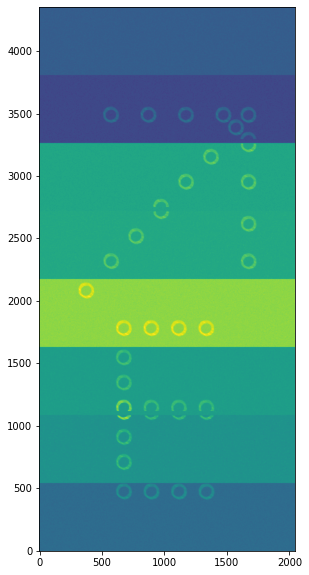

In [20]:
exposure = butler.get('raw', **dataId) 
image = exposure.image.array

fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=1050)


In [131]:
# show comcam : 

import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
#dataRoot='/project/scichris/aos/segmentation_update/comcam/arrows/input/'
#dataRoot='/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/'
dataRoot='/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input/'
butler = dafPersist.Butler(dataRoot, )
#dataId = dict(run='9006002', visit=4000021706002, raftName='R00', detectorName='SW0')
dataId = dict(run='9006001', visit=4000021706001, raftName='R22', detectorName='S12')
butler.datasetExists('raw', dataId)
#exposure = butler.get('raw', **dataId) 


True

In [81]:
#plt.hist(np.ravel(image), range)

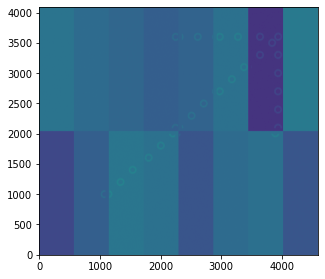

In [132]:
exposure = butler.get('raw', **dataId) 
image = exposure.image.array

fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image, origin='lower',vmin=900,vmax=1220)


In [10]:
hdul = fits.open('/project/scichris/aos/segmentation_update/famcam/raftR01/\
input/raw/2016-09-16/4016091609999/4016091609999-R01-S00-det000.fits')
#hdul[0].header

In [11]:
# show famcam ITL raft  : 

import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/aos/segmentation_update/famcam/raftR01/input/'
butler = dafPersist.Butler(dataRoot, )
dataId = dict(run='9999', visit=4016091609999, raftName='R01', detectorName='S12')
butler.datasetExists('raw', dataId)
#exposure = butler.get('raw', **dataId) 


True

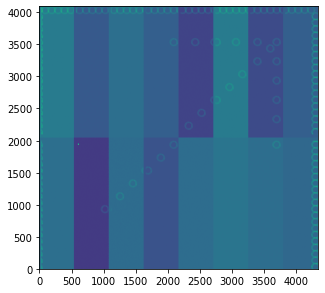

In [12]:
exposure = butler.get('raw', **dataId) 
image = exposure.image.array

fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image, origin='lower',vmin=900,vmax=1220)


### Make the calibs correctly, ingest them,  and run ISR on that image : 

Note: the LSST kernel sources the `/home/scichris/notebooks/.user_setups` for any user-specific setup I have added there 

    setup obs_lsst -t $USER -r /project/scichris/dev/obs_lsst/


So to use gain / readNoise same as in Robert's DM-28553 (which are the most up-to-date available for  lsstCam that I used to update `data/lsst/focalplanelayout` and `segmentation.txt`... But I need to check in the image header to see which readNoise / Gain values it jhas ... )


In [1]:
from astropy.io import fits

hdul = fits.open('/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/lsst_a_9006001_f1_R22_S12_C00_E000.fits.gz')

# check the value in the image header that phosim used ...
print(hdul[0].header['GAIN'])

# check the value that will be used by makeCalibs to make calibration files - must be the same ....
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
detector = camera['R22_S12']
amp = detector['C00']
print(amp.getGain())

1.11329
1.13693


In [3]:
#LsstCam??

1.11329


Ok, they're the same as the master branch , which means that I have used the old `obs_lsst` values when I was checking comcam (which makes sense because I only discovered the problem when working with lsstCam data and realising that one amplifier has 0.0 gain which caused divide by 0 error in makeCalibs ...)

So no need to change anything  in `dev/obs_lsst` - make sure it's set to master branch. 

In [28]:
from datetime import datetime
import argparse
from lsst.obs.lsst import LsstCam
import lsst.afw.image as afwImage
import numpy as np
import os 


just_wfs = False
detector_list = ["R22_S12"]#['R01_S00','R01_S01', 'R01_S02', 'R01_S10','R01_S11', 'R01_S12',
 #'R01_S20', 'R01_S21', 'R01_S22'] # ["R22_S12"]# ["R00_SW1"]

camera = LsstCam().getCamera()
if just_wfs:
    ccd_list = [camera[name] for name in ["R00_SW0", "R00_SW1", 
                                          "R04_SW0", "R04_SW1",
                                          "R44_SW0", "R44_SW1",
                                          "R40_SW0", 'R40_SW1']]
elif (detector_list is not None):
    ccd_list = [camera[name] for name in detector_list]
else:
    ccd_list = camera

for filt_name in 'g':
    for ccd in ccd_list:
        name = ccd.getName()
        print(name)
        CHIPID = "".join([c for c in name if c != "," and c != ":"])
        CHIPID = "_".join(CHIPID.split())
        image = afwImage.ImageF(ccd.getBBox())
        for amp in ccd:
            subim = afwImage.ImageF(image, amp.getBBox())
            subim[:] = 1/amp.getGain()
            #print(amp.getName(), amp.getGain())

        # need to flip the image to match the result of phosim repackager...
        oldImageArray = image.array.copy()
        image.array[:] = np.flipud(oldImageArray)

        expInfo = afwImage.ExposureInfo()
        inFilter = afwImage.FilterLabel(filt_name)
        expInfo.setFilterLabel(inFilter)
        exp = afwImage.ExposureF(afwImage.MaskedImageF(image), expInfo)
        md = exp.getMetadata()
        md.set('CHIPID', CHIPID)
        # Set place holder date
        md.set('MJD-OBS', 53005.0)
        md.set('OBSTYPE', 'flat')
        # arbitrary for flats
        md.set('EXPTIME', 100)
        # need to be able to specify any filter
        md.set('CALDATE', 53005.0)
        # Add the CALIB_ID header card
        md.set('CALIB_ID', 'raftName=%s detectorName=%s detector=%i filter=%s calibDate=%s' %
               (CHIPID.split('_')[0], CHIPID.split('_')[1], ccd.getId(), filt_name, datetime.now()))
        exp.setMetadata(md)
        exp.writeFits("%(name)s_%(filter)s.fits"%({'name': CHIPID, 'filter': filt_name}))


R22_S12


In [15]:
#afwImage.Filter.getNames()

In [4]:
afwImage.FilterLabel('g')

FilterLabel(band="g")

corner sensors :


    cp /home/scichris/notebooks/R00_SW0_g.fits .
    
    ingestCalibs.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input1/ /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/R00_SW0_g.fits --validity 99999 --output /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input1/
    
or 
   
    cp /home/scichris/notebooks/R00_SW1_g.fits .
   
    ingestCalibs.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/ /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/R00_SW1_g.fits --validity 99999 --output /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/
    
comcam:

    cp /home/scichris/notebooks/R22_S12_g.fits .
    ingestCalibs.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/R22_S12_g.fits --validity 99999 --output /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/
    
   or
   
    ingestCalibs.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input2/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/R22_S12_g.fits --validity 99999 --output /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input2/
    
   or
   
    ingestCalibs.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2020_52/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/R22_S12_g.fits --validity 99999 --output /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2020_52/
    
   or 
   
    ingestCalibs.py /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_08_rot/ /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/R22_S12_g.fits --validity 99999 --output /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_08_rot/
    
    
    
famcam 
    
    cp /home/scichris/notebooks/R01_*g.fits . 
    ingestCalibs.py /project/scichris/aos/segmentation_update/famcam/raftR01/input/ /project/scichris/aos/segmentation_update/famcam/R01_S*_g.fits --validity 99999 --output /project/scichris/aos/segmentation_update/famcam/raftR01/input/ 

Try running ISR with that calib, see if it works : 

corner sensors: 


    cp /project/scichris/aos/results_lsstfam_noCrosstalk2/input3/isr_config.py .
    
    config.isr.doBias=False
    config.isr.doDark=False
    config.isr.doFlat=True
    config.isr.doFringe=False
    config.isr.doDefect=False
    config.isr.doOverscan=True
    config.isr.doCrosstalk=False
    
    runIsr.py  /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input1/   --id  --rerun=run1  --configfile /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input1/isr_config.py  --no-versions
    
    
   or
    
    runIsr.py  /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/   --id  --rerun=run1  --configfile /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/isr_config.py  --no-versions
    
    
comcam 

    cd /project/scichris/aos/segmentation_update/comcam/arrows/input/ 
    cp /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/isr_config.py .
    
    runIsr.py  /project/scichris/aos/segmentation_update/comcam/arrows/input/   --id  --rerun=run1  --configfile /project/scichris/aos/segmentation_update/comcam/arrows/input/isr_config.py  --no-versions
    
    
   or
   
    cd /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/ 
    cp /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/isr_config.py .
    
    runIsr.py  /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/   --id  --rerun=run1  --configfile /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/isr_config.py  --no-versions
   
   or 
   
    runIsr.py  /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input2/   --id  --rerun=run1  --configfile /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input2/isr_config.py  --no-versions
    
    
    runIsr.py  /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2020_52/   --id  --rerun=run1  --configfile /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2020_52/isr_config.py  --no-versions
 
or (testing ROTPA, ROTANG removal...) 
    
    runIsr.py  /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_08_rot/   --id  --rerun=run1  --configfile /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input_2021_08_rot/isr_config.py  --no-versions
    
    
famcam  

    cd /project/scichris/aos/segmentation_update/famcam/raftR01/input/ 
    cp /project/scichris/aos/results_lsstfam_noCrosstalk2/input3/isr_config.py .
    
    runIsr.py  /project/scichris/aos/segmentation_update/famcam/raftR01/input/   --id  --rerun=run1  --configfile /project/scichris/aos/segmentation_update/famcam/raftR01/input/isr_config.py  --no-versions
    

In 2020_52 I had no issues, but in 2021_07 , I get two errors:  
    
    lsst.obs.lsst.translators.lsst WARN: 9006001: Unable to determine airmass of a science observation, returning 1.
    
    ...
    
         

Let's check the header : 

In [16]:
hdul = fits.open('/project/scichris/aos/segmentation_update/\
comcam/arrowsUpdSerial2/input2/raw/2000-02-17/4000021706001/4000021706001-R22-S12-det095.fits')

In [66]:
#hdul[1].header

Try `translate_header.py -p lsst.obs.lsst.translators /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input2/raw/2000-02-17/4000021706001/4000021706001-R22-S12-det095.fits`

### Show postISR image 

For corner sensors : 

In [49]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
#dataRoot='/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input1/'
dataRoot='/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input2/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
#dataId = dict(run='9006002', visit=4000021706002, raftName='R00', detectorName='SW0')
dataId = dict(run='9006002', visit=4000021706002, raftName='R00', detectorName='SW1')
post = postISRbutler.get('postISRCCD', **dataId) 
image = post.image.array


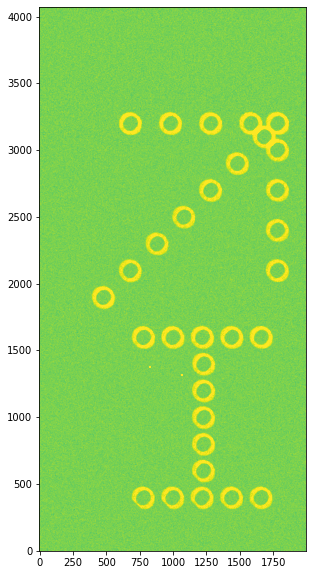

In [50]:
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=10,)#vmax=2600)


For comcam : 

`comcam/arrows/` used new x,y, but old serial / parallel read 

In [1]:
import os

import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist

dataRoot='/project/scichris/aos/segmentation_update/comcam/arrows/input/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006001', visit=4000021706001, raftName='R22', detectorName='S12')
post = postISRbutler.get('postISRCCD', **dataId) 
image = post.image.array


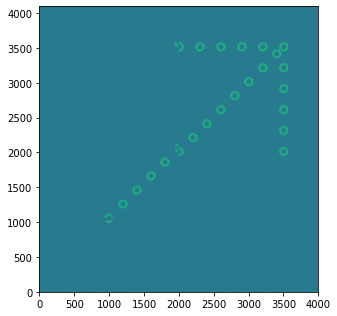

In [2]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=50,)#vmax=2600)


In [ ]:
# check the baseline, i.e. before the segmentation update
from astropy.io import fits
hdul = fits.open('/project/scichris/aos/segmentation_update/comcam/imgCloseLoop_base/iter0/img/extra/MC_H_20211231_006001_R22_S00.fits')


In [13]:
# check the arrows after the serial / parallel update 
hdul = fits.open('/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/repackaged/MC_H_20000217_006001_R22_S12.fits')

In [15]:
# check the arrows after the serial / parallel update  AND updated xlo,xhi,ylo,yhi (just the boundaries)
hdul = fits.open('/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S12.fits')

In [16]:
hdul[2].header['AMPID']

'C11'

In [17]:
for i in range(1,len(hdul)):
    for header in ['CD1_1', 'CD1_2', 'CD2_1', 'CD2_2']:
        print(i, hdul[i].header['AMPID'], hdul[i].header[header])

1 C10 0.0
1 C10 -5.55555555555556e-05
1 C10 -5.55555555555556e-05
1 C10 -0.0
2 C11 0.0
2 C11 -5.55555555555556e-05
2 C11 -5.55555555555556e-05
2 C11 -0.0
3 C12 0.0
3 C12 -5.55555555555556e-05
3 C12 -5.55555555555556e-05
3 C12 -0.0
4 C13 0.0
4 C13 -5.55555555555556e-05
4 C13 -5.55555555555556e-05
4 C13 -0.0
5 C14 0.0
5 C14 -5.55555555555556e-05
5 C14 -5.55555555555556e-05
5 C14 -0.0
6 C15 0.0
6 C15 -5.55555555555556e-05
6 C15 -5.55555555555556e-05
6 C15 -0.0
7 C16 0.0
7 C16 -5.55555555555556e-05
7 C16 -5.55555555555556e-05
7 C16 -0.0
8 C17 0.0
8 C17 -5.55555555555556e-05
8 C17 -5.55555555555556e-05
8 C17 -0.0
9 C07 -0.0
9 C07 5.55555555555556e-05
9 C07 5.55555555555556e-05
9 C07 0.0
10 C06 -0.0
10 C06 5.55555555555556e-05
10 C06 5.55555555555556e-05
10 C06 0.0
11 C05 -0.0
11 C05 5.55555555555556e-05
11 C05 5.55555555555556e-05
11 C05 0.0
12 C04 -0.0
12 C04 5.55555555555556e-05
12 C04 5.55555555555556e-05
12 C04 0.0
13 C03 -0.0
13 C03 5.55555555555556e-05
13 C03 5.55555555555556e-05
13 C

In [ ]:
hdul = fits.open('/project/scichris/aos/segmentation_update/comcam/\
arrows/input/raw/2000-02-17/4000021706001/4000021706001-R22-S12-det095.fits')
hdulCalib = fits.open('/project/scichris/aos/segmentation_update/comcam/arrows/\
input/flat/g/2021-02-17/flat_g-R22-S12-det095_2021-02-17.fits')


After updating serialread direction for E2V , so that no left-right flip needed for chips '00:07' (which was otherwise needed ...).

In [117]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist

dataRoot='/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006001', visit=4000021706001, raftName='R22', detectorName='S12')
post = postISRbutler.get('postISRCCD', **dataId) 
image = post.image.array


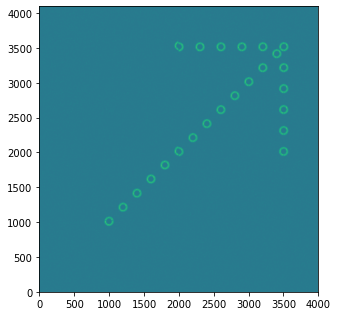

In [118]:
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=50,)#vmax=2600)


Also, updated the [xlo,xhi,ylo,yhi] for lower half of E2V chips (due to silly if statemtent, only half of the amps got updated ...)

In [134]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist

dataRoot='/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/input/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006001', visit=4000021706001, raftName='R22', detectorName='S12')
post = postISRbutler.get('postISRCCD', **dataId) 
image = post.image.array




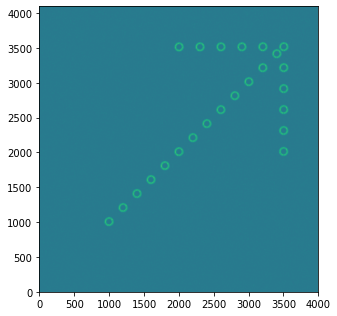

In [135]:
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=50,)#vmax=2600)


For famcam  ITL R01 raft : 

In [14]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist

dataRoot='/project/scichris/aos/segmentation_update/famcam/raftR01/input/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9999', visit=4016091609999, raftName='R01', detectorName='S12')
post = postISRbutler.get('postISRCCD', **dataId) 
image = post.image.array

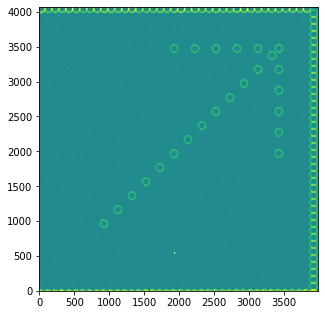

In [15]:
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=50,)#vmax=2600)


Show the imgCloseLoop postISR images : 
    m

It looks like we got it right . So to integrate the repackager and the makeGainImages into phosim_utils, and test the imgCloseLoop, need to go to NCSA or LSP, and make sure that `/project/scichris/dev/phosim_utils` is on ticket branch :

    cd /project/scichris/dev/phosim_utils/
    git checkout tickets/DM-26836
    
    
Then edit the makeGainImages and repackager files:

     sshfs scichris@lsst-login02.ncsa.illinois.edu:/project/scichris/dev/ ~/lsstdevl/
   
   
Then test that the repackaging works correctly: 
    
    # first ensure we're using the correct location for phosim_utils 
    cd /project/scichris/dev/phosim_utils/
    git checkout tickets/DM-26836   
    setup -k -r .
    
    # for corner sensors
    phosim_repackager.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/ --out_dir=/project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/repackaged/
    cd /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/
    mkdir inputTest
    cp input/_mapper inputTest/
    ingestImages.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/inputTest/ /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/repackaged/*.fits
   

   
Then run the AOS loop for comcam (on NCSA LSST-DEVL03 )  :  

    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    
    screen -S famcam
    ctrl+a , :logfile screenlog_210223_famcam.txt  # to set the location of screenlog
    ctrl+a, shift+h    # to start the screenlog 
    
    
    
    source "/software/lsstsw/stack3/loadLSST.bash"
    setup lsst_distrib 
    
    source "/project/scichris/aos/setup_aos_current.sh"   # which uses /project/scichris/aos/phosim_utils by default 
    
    cd /project/scichris/dev/phosim_utils/
    git checkout tickets/DM-26836     # for the branch with the new repackager and makeGains code 
    setup -k -r .    # this ensures we're using the dev location 
    
    cd /project/scichris/aos/ts_wep
    git checkout tickets/DM-28330  # for new mapper and for new e-image treatment 
    
    
    cd /project/scichris/dev/obs_lsst
    git checkout tickets/DM-28553
    scons # if needed 
    setup -k -r .
    ( R10, S00, C00 chip was the one with 0 gain .... ) 
    
    python /project/scichris/aos/test_lsstCam_R10_S00.py # to show the values of the troublesome chip
    
    
    cd /project/scichris/aos/ts_phosim   # to run the AOS .... 
    
for comcam (i.e. R22 of lsstCam) 

    python bin.src/imgCloseLoop.py --inst comcam --numOfProc 25 --boresightDeg 0.03 -0.02 --skyFile tests/testData/sky/skyComCam.txt --output /project/scichris/aos/segmentation_update/comcam/imgCloseLoop/

for famcam (i.e. lsstCam ) 
    
    python bin.src/imgCloseLoop.py --inst lsstfam --numOfProc 25 --boresightDeg 0.03 -0.02 --skyFile tests/testData/sky/skyLsstFam.txt --output /project/scichris/aos/segmentation_update/famcam/imgCloseLoop/
    
    

Also, run the AOS loop with the **default settings** on lsst-devl03 , to test whether after the updated focalplanelayout / segmentation we're getting similar values as before ... 


    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 

    screen -S famcamOld
    ctrl+a , :logfile screenlog_210223_famcamOld.txt  # to set the location of screenlog
    ctrl+a, shift+h    # to start the screenlog 


    source "/software/lsstsw/stack3/loadLSST.bash"
    setup lsst_distrib 

    source "/project/scichris/aos/setup_aos_current.sh"   # which uses /project/scichris/aos/phosim_utils by default 

    cd /project/scichris/aos/phosim_utils/
    git status   # shows we're on master
    
    cd /project/scichris/aos/ts_wep
    git checkout master  # shows we're on master 
    
    cd /project/scichris/aos/ts_phosim
    git checkout master # need to switch from ticket branch ... 
    
    cd /project/scichris/aos/phosim_syseng4/data/lsst
    cp segmentation_old.txt segmentation.txt
    cp focalplanelayout_old.txt focalplanelayout.txt   # to ensure we're using hte old ones ... 
    
    
    cd /project/scichris/aos/ts_phosim   # to run the AOS .... 
    
    python bin.src/imgCloseLoop.py --inst lsstfam --numOfProc 25 --boresightDeg 0.03 -0.02 --skyFile tests/testData/sky/skyLsstFam.txt --output /project/scichris/aos/segmentation_old/famcam/imgCloseLoop/

In [18]:
hdul = fits.open('/project/scichris/aos/segmentation_old/famcam/imgCloseLoop/iter0/img/extra/lsst_a_9006001_f1_R01_S11_E000.fits')

In [19]:
for i in range(1,len(hdul)):
    for header in ['CD1_1', 'CD1_2', 'CD2_1', 'CD2_2']:
        print(i, hdul[i].header['AMPID'], hdul[i].header[header])

1 C00 0.0
1 C00 5.55555555555556e-05
1 C00 -5.55555555555556e-05
1 C00 0.0
2 C01 0.0
2 C01 5.55555555555556e-05
2 C01 -5.55555555555556e-05
2 C01 0.0
3 C02 0.0
3 C02 5.55555555555556e-05
3 C02 -5.55555555555556e-05
3 C02 0.0
4 C03 0.0
4 C03 5.55555555555556e-05
4 C03 -5.55555555555556e-05
4 C03 0.0
5 C04 0.0
5 C04 5.55555555555556e-05
5 C04 -5.55555555555556e-05
5 C04 0.0
6 C05 0.0
6 C05 5.55555555555556e-05
6 C05 -5.55555555555556e-05
6 C05 0.0
7 C06 0.0
7 C06 5.55555555555556e-05
7 C06 -5.55555555555556e-05
7 C06 0.0
8 C07 0.0
8 C07 5.55555555555556e-05
8 C07 -5.55555555555556e-05
8 C07 0.0
9 C17 0.0
9 C17 -5.55555555555556e-05
9 C17 -5.55555555555556e-05
9 C17 -0.0
10 C16 0.0
10 C16 -5.55555555555556e-05
10 C16 -5.55555555555556e-05
10 C16 -0.0
11 C15 0.0
11 C15 -5.55555555555556e-05
11 C15 -5.55555555555556e-05
11 C15 -0.0
12 C14 0.0
12 C14 -5.55555555555556e-05
12 C14 -5.55555555555556e-05
12 C14 -0.0
13 C13 0.0
13 C13 -5.55555555555556e-05
13 C13 -5.55555555555556e-05
13 C13 -0.0

In [24]:
hdul.close()

In [ ]:
In the test above I failed to put the new version of `focalplanelayout.txt` in `ts_wep/policy`. Put the new version

Show the postISR images for famcam loop ( with updated segmentation/ focalplanelayout using RHLs new values from `DM-28553` : m

In [29]:

import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist

dataRoot='/project/scichris/aos/segmentation_update/famcam/imgCloseLoop/input/'
repoRoot = os.path.join(dataRoot, 'rerun/run1')  
postISRbutler = dafPersist.Butler(repoRoot, )


/project/scichris/dev/obs_lsst/python/lsst/obs/lsst/lsstCamMapper.py:157: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  for n in afwImage.Filter.getNames():
/project/scichris/dev/obs_lsst/python/lsst/obs/lsst/lsstCamMapper.py:157: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  for n in afwImage.Filter.getNames():


In [31]:
dataId = dict(run='9006002', visit=4021123106002, raftName='R01', detectorName='S11')
postISRbutler.datasetExists('postISRCCD', dataId=dataId)

True

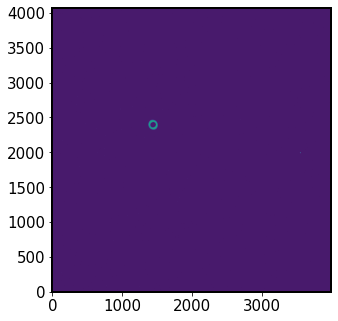

In [33]:
post = postISRbutler.get('postISRCCD', **dataId) 
image = post.image.array
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=500,)#vmax=2600)


In [14]:
# check out comcam images as they are being made with imgCloseLoop : 

# read the PSSN values for several iterations :
import numpy as np 
pssn = {}
med_pssn=[]
for i in range(3):
    pssn[i] = np.loadtxt('/project/scichris/aos/segmentation_update/comcam/imgCloseLoop/iter%s/img/PSSN.txt'%(str(i)))
    med_pssn.append(np.median(pssn[i][0]))

In [21]:
import numpy as np 
import matplotlib.pyplot as plt 

def plotIterationSummary(data_dir, iterNum=5, num_ccds=9, suptitle='', figname='1.png',
                          testLabel='1',opdPssnFileName='PSSN.txt'):
    '''Convenience function to make a 4-panel plot informing about the 
     convergence of AOS loop plotting :
     1) the OPD data in terms of Zernikes
     2) RMS WFS vs OPD in Zernikes
     3) PSSN as a function of iteration number 
     4) FWHM as a function of iteration number
     
    Parameters:
    ----------
    data_dir : str, a path to the AOS loop directory, eg. 
        '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/baselineTestComCam_qbkg'
    iterNum : float, a number of iterations (usually 5)
    num_ccds : float, a number of CCDs (field positions) for OPD evaluation. 
        For comcam it's usually 9 (one field point per CCD), for lsstcam/lsstfamcam 
        it's 31 (field points scattered across the full array)
    suptitle : str, a suptitle to apply to the figure
    figname : str, a filename to save the plot as 
    testLabel: str, a label to identify tests; by default in AOS loop '1', so that 
        we expect opd.zer.1 and wfs.zer.1   files to be present in iterX/img/ directory
        where X=0,1,2,3,4 etc. 
        
    Returns:
    --------
    None
     
    '''
    # two things to set 
    #iterNum = 5 # numer of iterations 
    #num_ccds = 9 # numer of CCDs at which OPD was evaluated 
    opdDataDic = {}
    wfsDataDic = {}
    pssn_data = []
    fwhm_data = []
    for iterCount in range(iterNum):
        # load the OPD data 
        opdZkFilePath = os.path.join(data_dir,  'iter%d/img/opd.zer'%(iterCount
                                                                         ))
        opdData = np.loadtxt(opdZkFilePath)
        opdDataDic[iterCount] = opdData

        # load the wavefront error data 
        wfsZkFilePath = os.path.join(data_dir,  'iter%d/img/wfs.zer'%(iterCount
                                                                         ))
        wfsData = np.loadtxt(wfsZkFilePath)
        wfsDataDic[iterCount] = wfsData

        # load the PSSN and FWHM data 
        pssn_filename = os.path.join(data_dir, 'iter%i' % iterCount, 
                                     'img/%s'%opdPssnFileName)
        pssn_file_array = np.genfromtxt(pssn_filename)
        pssn_data.append(pssn_file_array[0])
        fwhm_data.append(pssn_file_array[1])
    pssn_data = np.array(pssn_data)
    fwhm_data = np.array(fwhm_data)


    fig,axs = plt.subplots(2,2,figsize=(16,12))
    ax = np.ravel(axs)

    # 0: plot the OPD 

    # to compare the two, need  to somehow "average" the OPD ? 
    # plot the values of zernikes at different field points...
    for iterCount in range(iterNum):
        opdData = opdDataDic[iterCount]
    #     for i in range(np.shape(opdData)[0]):
    #         ax.plot(opdData[i,:], lw=1,ls='--')
        # plot the average of these ... 
        ax[0].plot(np.mean(opdData, axis=0), lw=3,ls='-' ,)

    ax[0].set_xlabel('Zernike #')
    ax[0].set_ylabel('wavefront error of OPD '+r'$[\mu m]$')


    # 1: plot Zernike wavefront errors  vs OPD 
    for iterCount in range(iterNum):
        wfsData = wfsDataDic[iterCount]
        opdData = opdDataDic[iterCount]
        # do the difference with mean OPD ... 
        meanOpdData = np.mean(opdData, axis=0)
        zernikeErrorsDiff = np.sqrt((wfsData - meanOpdData)**2.)

        zernikeErrors = np.transpose(zernikeErrorsDiff, axes=(1,0))

        zernikeRms = np.sqrt(np.mean(np.square(zernikeErrors), axis=1))

        ax[1].plot(np.arange(19)+4, zernikeRms, 
                      '-o', lw=3, label='iter%d'%iterCount)

    ax[1].set_xlabel('Zernike Number', size=18)
    ax[1].set_ylabel('RMS WFS vs OPD (microns)', size=18)

    ax[1].legend(fontsize=16)
    ax[1].set_title('Zernike Errors WFS ', size=18)


    # 2: plot PSSN 
    for i in range(num_ccds):
        ax[2].plot(np.arange(iterNum), pssn_data[:,i], c='b', marker='x')
    ax[2].plot(np.arange(iterNum), pssn_data[:,num_ccds], lw=4, marker='+',
             ms=20, markeredgewidth=5, c='r', label='GQ PSSN')
    ax[2].legend()
    ax[2].set_xlabel('Iteration')
    ax[2].set_ylabel('PSSN')
    ax[2].set_title('PSSN')
    # plt.xticks(size=14)
    # plt.yticks(size=14)


    # 3: plot the FWHM 
    for i in range(num_ccds):
        ax[3].plot(np.arange(iterNum), fwhm_data[:,i], c='b', marker='x')
    ax[3].plot(np.arange(iterNum), fwhm_data[:,num_ccds], lw=4, marker='+',
             ms=20, markeredgewidth=5, c='r', label='GQ FWHM_eff')
    ax[3].legend()
    ax[3].set_xlabel('Iteration')
    ax[3].set_ylabel('FWHM_eff (arcseconds)')
    ax[3].set_title('FWHM_eff')
    # plt.xticks(size=14)
    # plt.yticks(size=14)

    # on all : turn on the grid and set the x-label to be on integers only
    # since we're plotting Zernikes and iteration, both of which are integers
    for i in range(len(ax)):
        ax[i].grid()
        ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(suptitle)
    plt.savefig(figname, bbox_inches='tight')
    print('Saved fig as %s'%figname)



Saved fig as 1.png


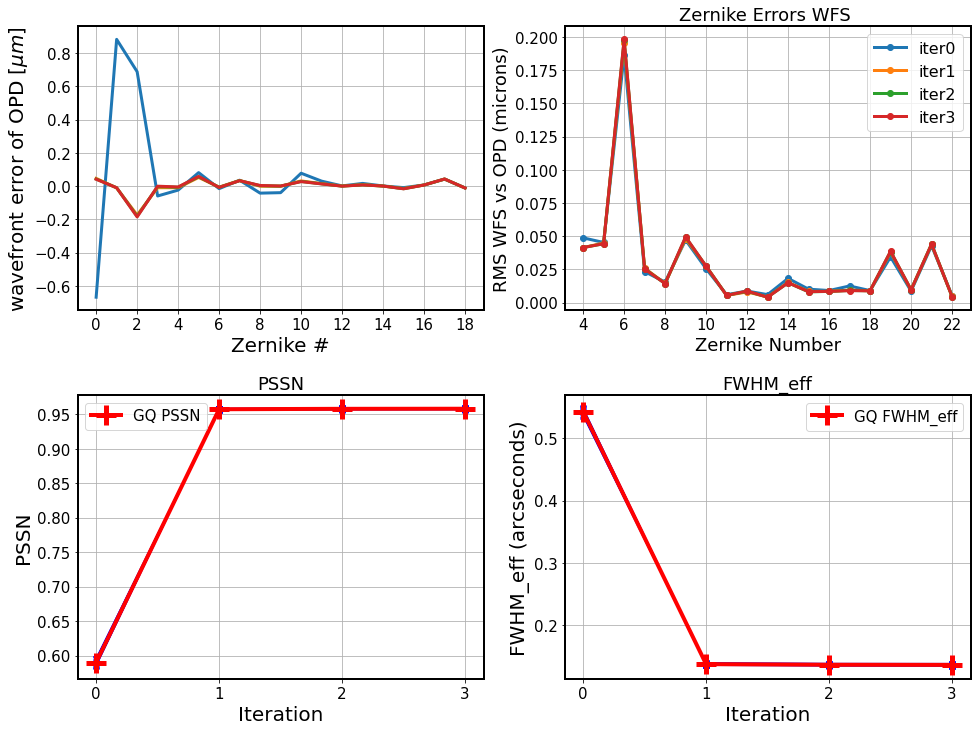

In [61]:
import os 
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

plotIterationSummary(data_dir='/project/scichris/aos/segmentation_update/comcam/imgCloseLoop/', 
                     iterNum=4, num_ccds=9, suptitle='', figname='1.png',
                     testLabel='1',opdPssnFileName='PSSN.txt')

Show comcam run on 3/3/2021 ,  usin the default ts_phosim stars,  with the following settins:
    
    
* aos/ts_wep   tickets/DM-28330 
* aos/phosim_utils  master    (v0.2., NEW repackager)
* aos/phosim_syseng4 master   (v1.0.5 , NEW  data/lsst  ... )
* aos/ts_phosim : master 
* aos/ts_ofc  : master 
* dev/obs_lsst : tickets/DM-28553   (for updated lsstCam gain / readNoise values - these are the ones in v1.0.5 of phosim_syseng4) ..


    python bin.src/imgCloseLoop.py --inst comcam --numOfProc 25 --boresightDeg 0.03 -0.02 --skyFile /tests/testData/skyComCam.txt --output /project/scichris/aos/segmentation_update/comcam/imgCloseLoop_base


Saved fig as comcam.png


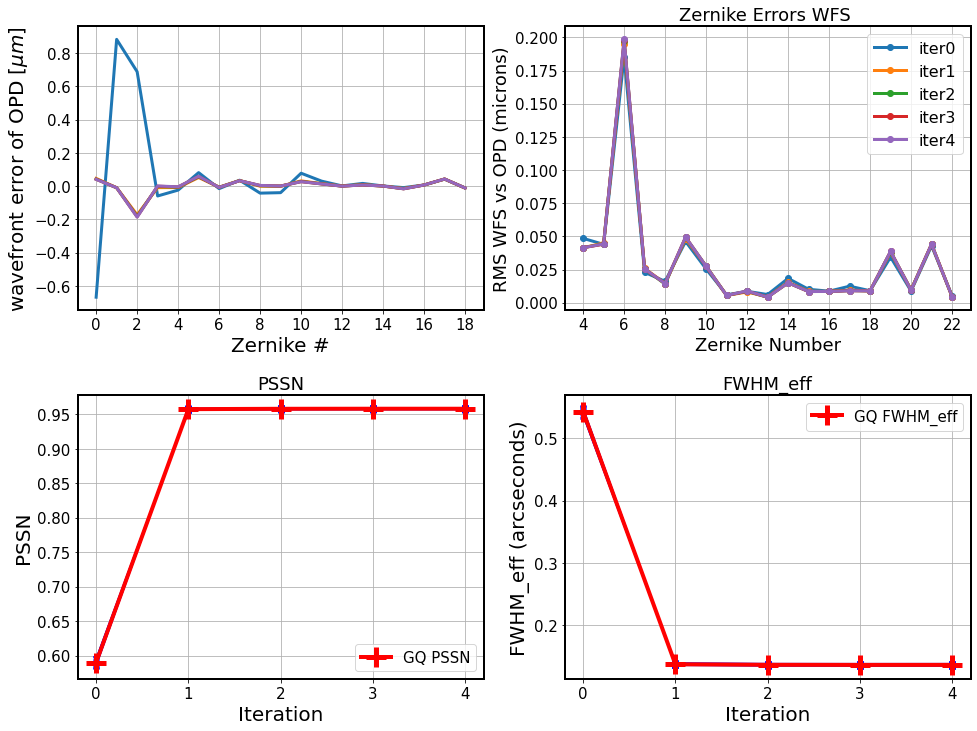

In [31]:

import os 
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

plotIterationSummary(data_dir='/project/scichris/aos/segmentation_update/comcam/imgCloseLoop_base/', 
                     iterNum=5, num_ccds=9, suptitle='', figname='comcam.png',
                     testLabel='1',opdPssnFileName='PSSN.txt')



Show famcam   using  `dev/obs_lsst` on `tickets/DM-28553`,  new phosim_utils,  and phosim_syseng4  with these obs_lsst values :

In [65]:
# check out famcam images as they are being made with imgCloseLoop : 

# read the PSSN values for several iterations :
import numpy as np 
pssn = {}
med_pssn =[]
for i in range(4):
    pssn[i] = np.loadtxt('/project/scichris/aos/segmentation_update/famcam/imgCloseLoop/iter%s/img/PSSN.txt'%(str(i)))
    med_pssn.append(np.median(pssn[i][0]))

In [66]:
med_pssn

[0.6010062642814309,
 0.9348854779842419,
 0.9344836619502191,
 0.9325777502657919]

[0.6010062642814309, 0.9355256686595956, 0.93407974463751]

Saved fig as 1.png


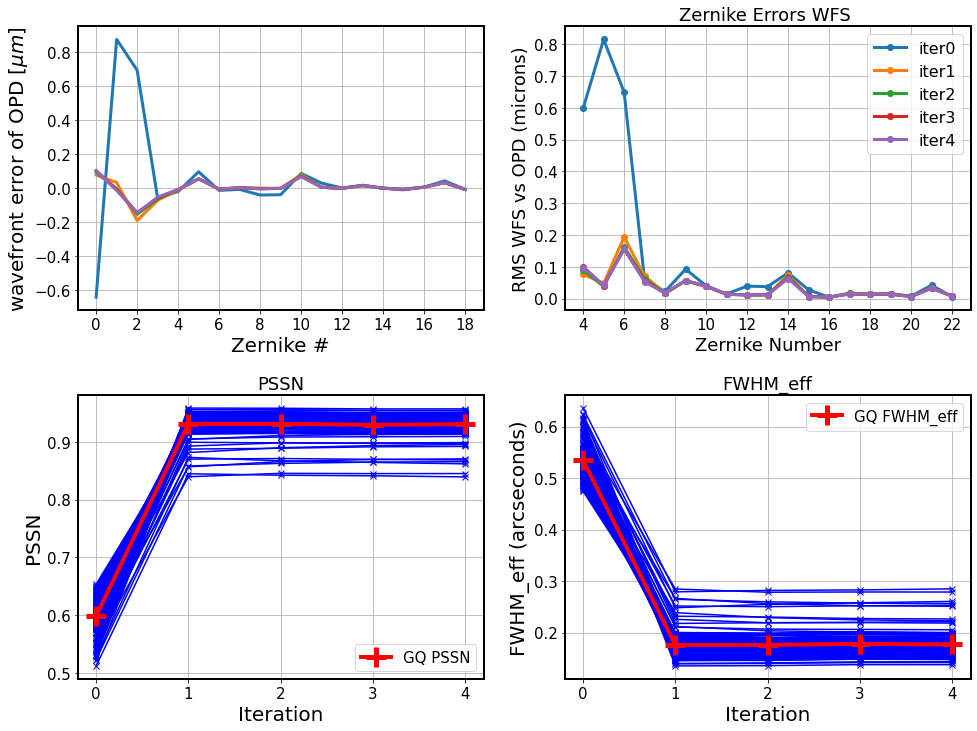

In [5]:
import os 
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

plotIterationSummary(data_dir='/project/scichris/aos/segmentation_update/famcam/imgCloseLoop/', 
                     iterNum=5, num_ccds=189, suptitle='', figname='1.png',
                     testLabel='1',opdPssnFileName='PSSN.txt')

Also show what were the numbers using old segmentation (and `obs_lsst` at master, using `phosimMapper` data, and old `phosim_syseng4` data ... )

Saved fig as 1_old.png


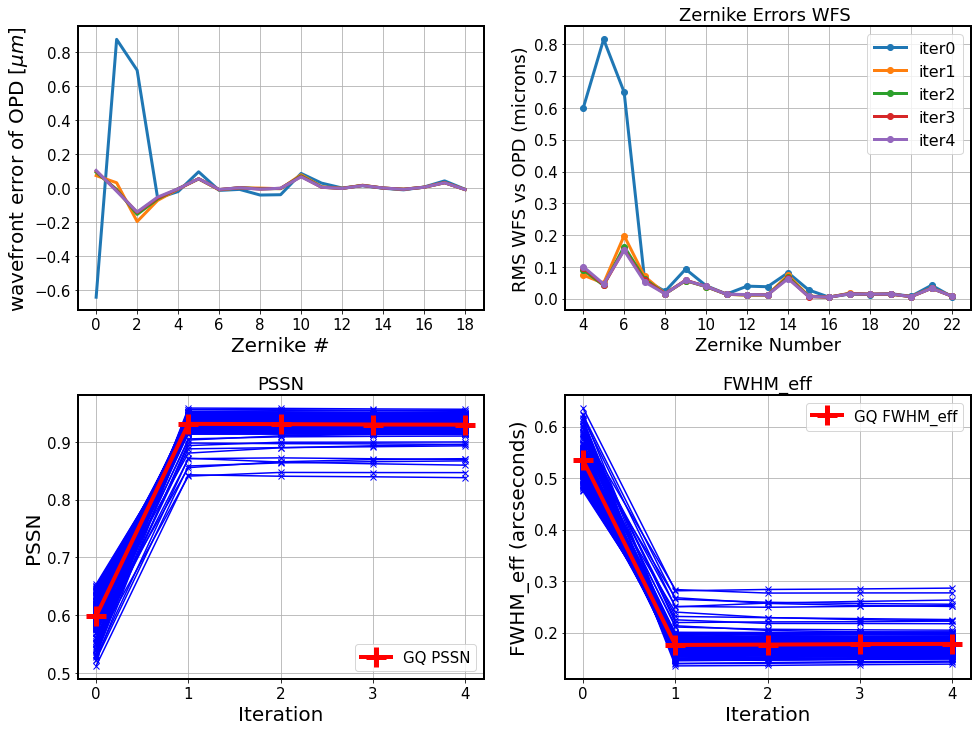

In [6]:
import os 
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

plotIterationSummary(data_dir='/project/scichris/aos/segmentation_old/famcam/imgCloseLoop/', 
                     iterNum=5, num_ccds=189, suptitle='', figname='1_old.png',
                     testLabel='1',opdPssnFileName='PSSN.txt')

Compare the values of **median PSSN** for famcam before & after the update of segmentation and focalplanelayout.txt ... 

In [7]:
# check out famcam images as they are being made with imgCloseLoop : 

# read the PSSN values for several iterations :
import numpy as np 
pssn = {}
med_pssn ={}
for test in ['old', 'update']:
    med_pssn[test]=[]
    for i in range(5):
        pssn[i] = np.loadtxt('/project/scichris/aos/segmentation_%s/famcam/imgCloseLoop/iter%s/img/PSSN.txt'%(test,str(i)))
        med_pssn[test].append(np.median(pssn[i][0]))


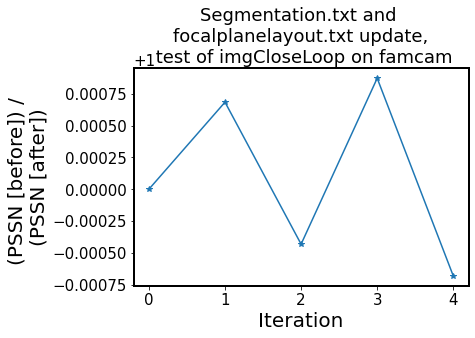

In [11]:
plt.xlabel('Iteration')
plt.ylabel('(PSSN [before]) / \n(PSSN [after])')
plt.title('Segmentation.txt and \nfocalplanelayout.txt update,\n test of imgCloseLoop on famcam')
plt.plot(np.array(med_pssn['old'])  /np.array(med_pssn['update']), marker='*')

I think this shows that the update still allows the loop to converge, i.e. looks good ! PSSN -  Normalized Point Source Sensitivity -  is a unitless ratio: https://github.com/lsst-ts/ts_phosim/blob/5eb96fdfb29ccef77e00e1b47adcf4e1ba081d0f/python/lsst/ts/phosim/MetroTool.py#L89 , defined in Document-17242 ( Angeli+2016) . 

## Update the tag for phosim_utils 

After the merge of my PR to master, I do 

    cd /project/scichris/dev/phosim_utils
    git checkout master
    git tag -a v0.2 -m "Merge pull request #12 from lsst-dm/tickets/DM-26836"
    
    git tag -ln   # shows all tags 
    
    
    git push origin --tags 

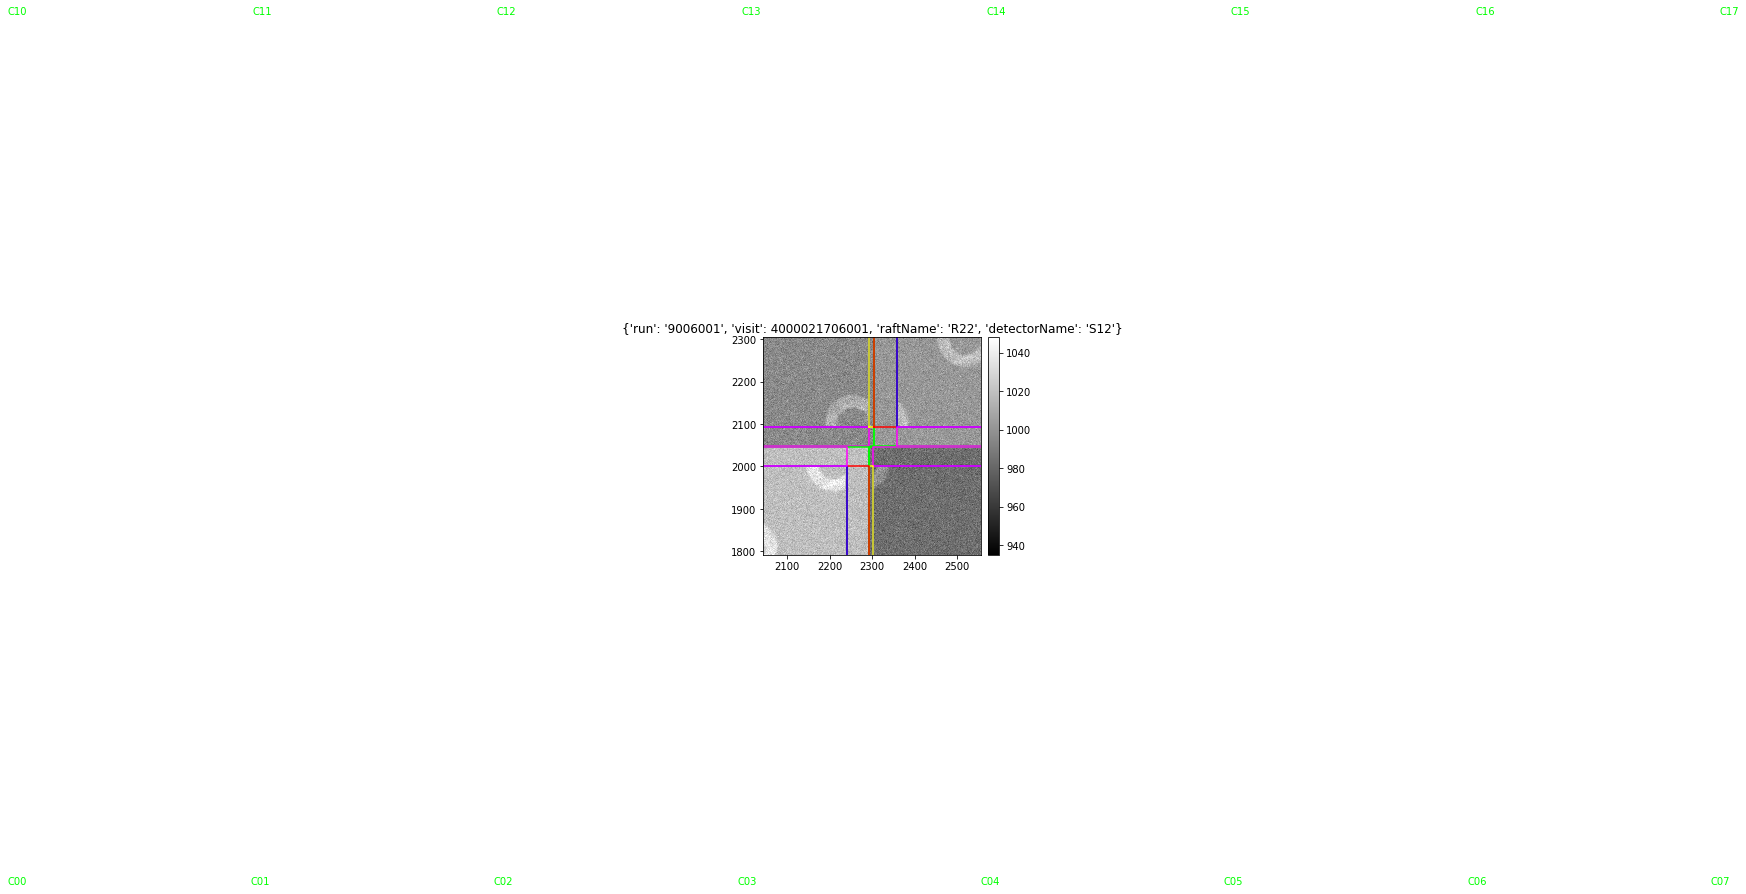

In [122]:
import lsst.afw.display as afwDisplay
import lsst.afw.cameraGeom.utils as cgUtils

import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
#dataRoot='/project/scichris/aos/segmentation_update/comcam/arrows/input/'
dataRoot='/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/input/'
butler = dafPersist.Butler(dataRoot, )
#dataId = dict(run='9006002', visit=4000021706002, raftName='R00', detectorName='SW0')
dataId = dict(run='9006001', visit=4000021706001, raftName='R22', detectorName='S12')
#butler.datasetExists('raw', dataId)
exposure = butler.get('raw', **dataId) 



afwDisplay.setDefaultBackend("matplotlib")
disp = afwDisplay.Display(2, reopenPlot=True)
disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
disp.setImageColormap('gray')
disp.scale('linear', *(['zscale'] if True else [12340, 12470]))
disp.mtv(exposure, title=f"{dataId}")
cgUtils.overlayCcdBoxes(exposure.getDetector(), isTrimmed=False, display=disp)
disp.zoom(16, 2300, 2048)

In [123]:
import lsst.geom as geom
import lsst.afw.cameraGeom as cameraGeom
for detector in camera:
    bbox = detector.getBBox()
    xp, yp = detector.getCenter(cameraGeom.FOCAL_PLANE)  # centre of CCD
    yaw = detector.getOrientation().getYaw().asDegrees()  # rotation in the plane of the camera  (also getPitch() and getRoll(); see afw/cameraGeom/Orientation.h)
    print(f"{detector.getName():10} ({xp:9.4f}, {yp:9.4f}) mm  {yaw} deg")

R01_S00    (-169.2600, -296.2600) mm  0.0 deg
R01_S01    (-127.0100, -296.2600) mm  0.0 deg
R01_S02    ( -84.7600, -296.2600) mm  0.0 deg
R01_S10    (-169.2600, -254.0100) mm  0.0 deg
R01_S11    (-127.0100, -254.0100) mm  0.0 deg
R01_S12    ( -84.7600, -254.0100) mm  0.0 deg
R01_S20    (-169.2600, -211.7600) mm  0.0 deg
R01_S21    (-127.0100, -211.7600) mm  0.0 deg
R01_S22    ( -84.7600, -211.7600) mm  0.0 deg
R02_S00    ( -42.2600, -296.2600) mm  0.0 deg
R02_S01    (  -0.0100, -296.2600) mm  0.0 deg
R02_S02    (  42.2400, -296.2600) mm  0.0 deg
R02_S10    ( -42.2600, -254.0100) mm  0.0 deg
R02_S11    (  -0.0100, -254.0100) mm  0.0 deg
R02_S12    (  42.2400, -254.0100) mm  0.0 deg
R02_S20    ( -42.2600, -211.7600) mm  0.0 deg
R02_S21    (  -0.0100, -211.7600) mm  0.0 deg
R02_S22    (  42.2400, -211.7600) mm  0.0 deg
R03_S00    (  84.7400, -296.2600) mm  0.0 deg
R03_S01    ( 126.9900, -296.2600) mm  0.0 deg
R03_S02    ( 169.2400, -296.2600) mm  0.0 deg
R03_S10    (  84.7400, -254.0100) 